#  Exploratory data analysis and Pre-Processing for How2 Data. 

Following are the high level pre-processing steps:

* **Step-1 :** Define text processing functions.
* **Step-2 :** Load data from How2 text files. 
 * tran.tok.txt
 * desc.tok.txt
* **Step-3 :** Experimenting with entities. 
* **Step-4 :** Data Visualizaition 
* **Step-5 :** Save dataset as CSV for use in next step (building a model) 

Output CSV Column Description:
* **summary  :** Summary provided with the article.  
* **article  :** Raw text of the article that has the transcript of the spoken words. 
* **data_source  :** Source of Data which is How2 dataset.  
* **article_pp1  :** Processed text of the article - Remove stop words, punctuations and lemmatize text. 
* **article_pp2  :** Processed text of the article - Fix duplicate punctuations and remove line breks and other items.  
* **num_words_article  :** Num of words in the article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_article  :** Num of sentences in the article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_words_summary  :**  Num of words in the summary. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_summary  :** Num of sentences in the summary. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_words_article_pp1  :**  Num of words in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_article_pp1  :** Num of sentences in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_words_article_pp2  :**  Num of words in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  
* **num_sentences_article_pp2  :** Num of sentences in the pre-processed article. This is to save processing in the next steps where we dont have to compute these statistics.  

In [1]:
import re
import string
import os 
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
from pprint import pprint
from collections import Counter
import en_core_web_md
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords



nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')
nlp = en_core_web_md.load()
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

#stopwords = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package words to /home/sunitc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sunitc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sunitc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##  Step-1 : Define text processing and helper functions.

In [2]:
####################
# Clean Text Fxnx  #
####################


def remove_non_en_words(text):
    valid_words = [w for w in text.split() if w in english_vocab]
    return " ".join(valid_words)

def remove_Stopwords(text):
    stop_words = set(stopwords.words('english')) 
    words = word_tokenize( text.lower() ) 
    sentence = [w for w in words if not w in stop_words]
    return " ".join(sentence)
    

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    for sentence in sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    return ' '.join(wordlist) 

def clean_text2(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr]) 
    return text2.lower()



def isNaN(num):
    return num != num

def Clean_Text(out):
    if isNaN(out):
        return out
    else:
        if not out.strip().isspace():
            #out = out.replace('0', '')        
            out = out.strip()
            out = out.replace('\\x92', ' ')
            out = out.replace('\\x93', ' ')
            out = out.replace('\\x94', ' ')
            out = out.replace('\\x96', ' ')
            out = out.replace('/', ' ')
            out = out.replace('%20', ' ')
            out = out.replace('"', ' ')
            out = out.replace('\\', ' ')
            out = out.replace(';', '')
            out = out.replace('...', '.')
            out = out.replace('.,', '.')
            out = out.replace('?', '? ')
            out = out.replace('!', '! ')
            out = out.replace(',', ', ')
            out = out.replace('’', '\'')
            out = out.replace('`', '\'')
            out = out.replace('\r\n', '.')     
            out = out.replace('\n', '.') 
            out = out.replace('hey', ' ')
            out = out.replace('hi there', ' ')
            out = out.replace('.o.k.', 'ok')
            out = out.replace('o.k.', 'ok')
            out = out.replace('n''t', 'not')
            out = out.replace('hello', ' ')
            out = out.replace('°', ' degrees ')
            out = out.replace('  ', ' ')
            out = out.replace('..', '.')
            out = out.replace('..,', '.')
            out = out.replace('. ,', '.')
            out = out.replace('.,', '.')
            
        return out

    
def normalize_text(text):
    tm1 = re.sub('<pre>.*?</pre>', '', text, flags=re.DOTALL)
    tm2 = re.sub('<code>.*?</code>', '', tm1, flags=re.DOTALL)
    tm3 = re.sub('<[^>]+>', '', tm1, flags=re.DOTALL)
    return tm3.replace("\n", "")

def Get_Num_Words(text):
    if type(text) == str:
        return len(text.split())
    else:
        return 0
    
def Get_Num_Sentences(text):
    if type(text) == str and '.' in text:
        return len(text.split('.'))
    else:
        return 1    
    
def RemoveIntroFromText(script):
    sentences = [x for x in script.sents]
    i=0
    new_text=""
    print("Original text: \n")
    displacy.render(script, jupyter=True, style='ent')
    print("Some preprocessing details: \n************\n")
    is_intro=False
    
    for sent in sentences:
        at_least_one_person=0
        #print("Sentence ", i, ": ", sentences[i])
        d= dict([(str(x), x.label_) for x in nlp(str(sent)).ents])
        #print(d)
        if len(d)>0:
            print(d)
            for key in d:
                #print("key:",key, "; value=", d[key])
                #print(sent)
                if (d[key]=="PERSON"):
                    at_least_one_person+=1
        if "expertvillage" in str(sent).lower() or "expert village" in str(sent).lower():
            is_intro=True
        if (at_least_one_person>0):
            print("the sentence has at least one person:")
            print("Sentence ", i, ": ", sentences[i])    
        if (i<4 and (at_least_one_person>0  or is_intro)):
            print("the sentence is likely an introduction")
            new_text=''
        else:
            new_text+=str(sent)
            if not (str(sent).strip()[-1] in string.punctuation): 
                print ("Missing punctuation at the end", sent, "; last char is ", str(sent).strip()[-1])
                new_text+=". "
        i+=1
    print("\n*************\n Updated text - removed person introduction:\n*************\n", new_text)
    return new_text


def RemoveIntroFromTextNonVerbose(instr):
    try:
        script = nlp(instr)
        sentences = [x for x in script.sents]
        #print("Sentence len=", len(sentences))
        i=0
        new_text="" 
        #displacy.render(script, jupyter=True, style='ent') 
        is_intro=False

        for sent in sentences:
            at_least_one_person=0
            d= dict([(str(x), x.label_) for x in nlp(str(sent)).ents])
            if len(d)>0:
                for key in d:
                    if (d[key]=="PERSON"):
                        at_least_one_person+=1
            if "expertvillage" in str(sent).lower() or "expert village" in str(sent).lower():
                is_intro=True
            if (i<4 and (at_least_one_person>0  or is_intro)):
                 new_text=''
            else:
                new_text+=str(sent)
                if not (str(sent).strip()[-1] in string.punctuation): 
                     new_text+=". "
            i+=1
        return new_text
    except:
        return " "



#  Step-2 : Load data from How2 text files. 

In [3]:
# purpose of this code is to read the full_text from the text file and put it in a dataframe/csv

f1 = lambda x: x[0].split(" ")[0]
f2 = lambda x: x[0].partition(" ")[2]

filepath=os.getcwd() + "/data/tran.tok.txt"
df_source = pd.read_csv(filepath, sep="~" , header=None, skiprows=0, skipinitialspace=True)

df_source["key"] = df_source.apply(f1, axis=1)
df_source["text"] = df_source.apply(f2, axis=1)

filepath_s=os.getcwd() + "/data/desc.tok.txt"
df_target = pd.read_csv(filepath_s, sep="~" , header=None, skiprows=0, skipinitialspace=True)
df_target["key2"] = df_target.apply(f1, axis=1)
df_target["summary"] = df_target.apply(f2, axis=1)

how2_df=df_source.set_index('key').join(df_target.set_index('key2'), lsuffix='_caller', rsuffix='_other')  
how2_df = how2_df.reset_index()
    
# Clean up the column names and add number of words and sentences. 

how2_df['data_source'] = 'How2'
how2_df = how2_df[['summary','text','data_source']]
how2_df.columns = ['summary','article','data_source']
how2_df

,summary,article,data_source
0,learn the sivananda yoga single right leg rais...,after you 've done at least six to twelve roun...,How2
1,learn how to apply hanger hooks for your woodc...,"on behalf of expert village , my name is husai...",How2
2,learn about how hand washing can help prevent ...,hi ! this is david jackel on behalf of expert ...,How2
3,how to julienne cucumbers to make kimchi for k...,the other way we can do cucumbers which is als...,How2
4,in order to put photographic emulsion on water...,my name is anthony maddaloni and i 'm going to...,How2
...,...,...,...
2515,newfoundlands are giant dogs with very heavy c...,i 'm nancy frensley with the berkeley east bay...,How2
2516,martial arts stretches focus on increasing fle...,my name is william sampson and i am with unite...,How2
2517,avoid getting fired at an office christmas par...,"so , you 've just been invited to your office ...",How2
2518,how to select stones for thinning in this free...,"hi , i 'm john olsen for expert village . and ...",How2


In [4]:
# remove intro from article, remove stop words, lemmatize and clean text. 

how2_df['article_pp1'] = how2_df['article'].apply(RemoveIntroFromTextNonVerbose)
how2_df['article_pp1'] = how2_df['article_pp1'].apply(clean_text2)
how2_df['article_pp1'] = how2_df['article_pp1'].apply(remove_Stopwords)
how2_df['article_pp1'] = how2_df['article_pp1'].apply(lemmatize_text)
#how2_df['article_pp1'] = how2_df['article_pp1'].apply(remove_non_en_words)

how2_df

,summary,article,data_source,article_pp1
0,learn the sivananda yoga single right leg rais...,after you 've done at least six to twelve roun...,How2,done least six twelve round sun salutation siv...
1,learn how to apply hanger hooks for your woodc...,"on behalf of expert village , my name is husai...",How2,think going hang right okay okay need another ...
2,learn about how hand washing can help prevent ...,hi ! this is david jackel on behalf of expert ...,How2,cold come direct contact somebody else virus o...
3,how to julienne cucumbers to make kimchi for k...,the other way we can do cucumbers which is als...,How2,way cucumber also nice pickling cucumber find ...
4,in order to put photographic emulsion on water...,my name is anthony maddaloni and i 'm going to...,How2,photograph emulsion heat emulsion light tight ...
...,...,...,...,...
2515,newfoundlands are giant dogs with very heavy c...,i 'm nancy frensley with the berkeley east bay...,How2,talk newfoundland newfoundland newfies called ...
2516,martial arts stretches focus on increasing fle...,my name is william sampson and i am with unite...,How2,couple basic type stretch appropriate differen...
2517,avoid getting fired at an office christmas par...,"so , you 've just been invited to your office ...",How2,first main thing need remember office christma...
2518,how to select stones for thinning in this free...,"hi , i 'm john olsen for expert village . and ...",How2,manipulate back forth chipping small flake fat...


In [5]:
# remove intro from article, remove stop words, lemmatize and clean text. 

how2_df['article_pp2'] = how2_df['article'].apply(RemoveIntroFromTextNonVerbose)
how2_df['article_pp2'] = how2_df['article_pp2'].apply(Clean_Text)
how2_df


,summary,article,data_source,article_pp1,article_pp2
0,learn the sivananda yoga single right leg rais...,after you 've done at least six to twelve roun...,How2,done least six twelve round sun salutation siv...,after you 've done at least six to twelve roun...
1,learn how to apply hanger hooks for your woodc...,"on behalf of expert village , my name is husai...",How2,think going hang right okay okay need another ...,we have to think about how that is going to ha...
2,learn about how hand washing can help prevent ...,hi ! this is david jackel on behalf of expert ...,How2,cold come direct contact somebody else virus o...,most colds come from direct conotact that you ...
3,how to julienne cucumbers to make kimchi for k...,the other way we can do cucumbers which is als...,How2,way cucumber also nice pickling cucumber find ...,the other way we can do cucumbers which is als...
4,in order to put photographic emulsion on water...,my name is anthony maddaloni and i 'm going to...,How2,photograph emulsion heat emulsion light tight ...,now photographs have an emulsion on them .and ...
...,...,...,...,...,...
2515,newfoundlands are giant dogs with very heavy c...,i 'm nancy frensley with the berkeley east bay...,How2,talk newfoundland newfoundland newfies called ...,we 're here to talk about newfoundlands .the n...
2516,martial arts stretches focus on increasing fle...,my name is william sampson and i am with unite...,How2,couple basic type stretch appropriate differen...,there are a couple basic types of stretches an...
2517,avoid getting fired at an office christmas par...,"so , you 've just been invited to your office ...",How2,first main thing need remember office christma...,"first of all , the main thing you need to reme..."
2518,how to select stones for thinning in this free...,"hi , i 'm john olsen for expert village . and ...",How2,manipulate back forth chipping small flake fat...,and i manipulate that back and forth by chippi...


In [6]:
# remove non words. 
how2_df['article_pp3'] = how2_df['article_pp1'].apply(remove_non_en_words)
how2_df

,summary,article,data_source,article_pp1,article_pp2,article_pp3
0,learn the sivananda yoga single right leg rais...,after you 've done at least six to twelve roun...,How2,done least six twelve round sun salutation siv...,after you 've done at least six to twelve roun...,done least six twelve round sun salutation yog...
1,learn how to apply hanger hooks for your woodc...,"on behalf of expert village , my name is husai...",How2,think going hang right okay okay need another ...,we have to think about how that is going to ha...,think going right need another wire need anoth...
2,learn about how hand washing can help prevent ...,hi ! this is david jackel on behalf of expert ...,How2,cold come direct contact somebody else virus o...,most colds come from direct conotact that you ...,cold come direct contact somebody else virus o...
3,how to julienne cucumbers to make kimchi for k...,the other way we can do cucumbers which is als...,How2,way cucumber also nice pickling cucumber find ...,the other way we can do cucumbers which is als...,way cucumber also nice cucumber find work best...
4,in order to put photographic emulsion on water...,my name is anthony maddaloni and i 'm going to...,How2,photograph emulsion heat emulsion light tight ...,now photographs have an emulsion on them .and ...,photograph emulsion heat emulsion light tight ...
...,...,...,...,...,...,...
2515,newfoundlands are giant dogs with very heavy c...,i 'm nancy frensley with the berkeley east bay...,How2,talk newfoundland newfoundland newfies called ...,we 're here to talk about newfoundlands .the n...,talk newfoundland newfoundland people love kee...
2516,martial arts stretches focus on increasing fle...,my name is william sampson and i am with unite...,How2,couple basic type stretch appropriate differen...,there are a couple basic types of stretches an...,couple basic type stretch appropriate differen...
2517,avoid getting fired at an office christmas par...,"so , you 've just been invited to your office ...",How2,first main thing need remember office christma...,"first of all , the main thing you need to reme...",first main thing need remember office christma...
2518,how to select stones for thinning in this free...,"hi , i 'm john olsen for expert village . and ...",How2,manipulate back forth chipping small flake fat...,and i manipulate that back and forth by chippi...,manipulate back forth chipping small flake fat...


In [7]:
print("Displaying 1 Article and Summary")
article = how2_df.iloc[3]['article']
articlepp1 = how2_df.iloc[3]['article_pp1']
print("Artlen:", len(article), "ArtPP-len", len(articlepp1))
print("---Article--------------------------------------------------------------------------------------------------------")
print(article)
print("---Article_PP1--------------------------------------------------------------------------------------------------------")
print(articlepp1)


Displaying 1 Article and Summary
Artlen: 813 ArtPP-len 360
---Article--------------------------------------------------------------------------------------------------------
the other way we can do cucumbers which is also very nice is on these pickling cucumbers i find out that works out the best because they are firmer is to slice them diagonally . same thing about 1/8 '' to 1/4 '' you can cut them a little bit thicker if were going to use this style because well you 'll see why what were going to do once we 're doing this . turn them on the side we 're going to cut them into strips and that ones are pickled it 's going to make them nice soft and flexible but still have the good crunch . be careful not to cut your fingers because you ca n't enjoy your meal if your fingers are missing , same thing with the ends . we 're going to bring our bowl over and i 'm just going to mix them all together because as you see the process is the same no matter how you cut your cucumbers .
---Article_P

In [8]:
how2_df.describe()

,summary,article,data_source,article_pp1,article_pp2,article_pp3
count,2520,2520,2520,2520,2520,2520
unique,2519,2513,1,2496,2496,2495
top,the whammy guitar effect is similar to an octa...,chinese writing is very different from most ot...,How2,,,
freq,2,5,2520,19,19,20


In [9]:
## TODO plot the sentence and words in matplot lib - 4 plots. 

In [10]:
# extract one article and one summary value from dataframe 

print("Displaying a single Article and its Summary")
article = how2_df.iloc[2]['article']
summary = how2_df.iloc[2]['summary']
print("---Summary--------------------------------------------------------------------------------------------------------")
print(summary)
print("---Article--------------------------------------------------------------------------------------------------------")
print(article)


Displaying a single Article and its Summary
---Summary--------------------------------------------------------------------------------------------------------
learn about how hand washing can help prevent you from catching a cold in this free health video series .
---Article--------------------------------------------------------------------------------------------------------
hi ! this is david jackel on behalf of expert village and i 'm here to talk to you about washing your hands to prevent a cold . now hand washing is actually one of the best ways to prevent catching a cold . the germs that you would catch , travel through your hands onto other parts of your body , specifically your face . most colds come from direct contact that you 're having with somebody else who has the virus . often times that 's like shaking hands with somebody , being in close quarters , hugging , touching , anything when you 're close with somebody else , sharing things , touching the same glass , touching

# Step-3 Experimenting with entities.

In [11]:
# use nlp to load article in third row of dataset. (random row)
article = how2_df.iloc[2]['article']
summary = how2_df.iloc[2]['summary']
script_article = nlp(article)
result = RemoveIntroFromText(script_article)

Original text: 



Some preprocessing details: 
************

{'david jackel': 'PERSON'}
the sentence has at least one person:
Sentence  1 :  this is david jackel on behalf of expert village and i 'm here to talk to you about washing your hands to prevent a cold .
the sentence is likely an introduction
{'one': 'CARDINAL'}
the sentence is likely an introduction
the sentence is likely an introduction
{'close quarters': 'DATE'}
{'at least 20 seconds': 'TIME'}

*************
 Updated text - removed person introduction:
*************
 most colds come from direct contact that you 're having with somebody else who has the virus .often times that 's like shaking hands with somebody , being in close quarters , hugging , touching , anything when you 're close with somebody else , sharing things , touching the same glass , touching the same silverware , touching the same food , stuff like that .so what you should do is constantly be washing your hands , especially if you 're traveling or if you 're in close quarter

In [12]:
# use nlp to load article in third row of dataset. (random row)
article = how2_df.iloc[821]['article']
summary = how2_df.iloc[821]['summary']
script_article = nlp(article)
result = RemoveIntroFromText(script_article)


Original text: 



Some preprocessing details: 
************

{'o.k.': 'PERSON'}
the sentence has at least one person:
Sentence  0 :  o.k. , this drill is what you do is called drop and hit .
the sentence is likely an introduction
{'one': 'CARDINAL'}
{'maya': 'PERSON'}
the sentence has at least one person:
Sentence  6 :  so , maya hit these over the net .
{'aidan': 'PERSON'}
the sentence has at least one person:
Sentence  8 :  and aidan , i 'm going to drop one for you .
{'o.k . aidan': 'PERSON'}
the sentence has at least one person:
Sentence  10 :  o.k . aidan , here we go .
{'aidan': 'PERSON'}
the sentence has at least one person:
Sentence  14 :  aidan , you 're ready ?
{'aidan': 'PERSON'}
the sentence has at least one person:
Sentence  15 :  aidan , that 's unbelievably great .
{'aidan': 'PERSON'}
the sentence has at least one person:
Sentence  16 :  alright , aidan .
{'one': 'CARDINAL'}
{'o.k.': 'PERSON'}
the sentence has at least one person:
Sentence  26 :  o.k.
{'one': 'CARDINAL'}
{'aidan': 'PERSON

### Extracting sentences 

In [13]:
# extract sentences

sentences = [x for x in script_article.sents]
i=0
for sent in sentences:
    print("Sentence ", i, ": ", sentences[i])
    d= dict([(str(x), x.label_) for x in nlp(str(sent)).ents])
    print(d)
    i+=1
    
    

Sentence  0 :  o.k. , this drill is what you do is called drop and hit .
{'o.k.': 'PERSON'}
Sentence  1 :  so i 'm going to have the kids drop and hit the ball .
{}
Sentence  2 :  and i 'm going to work with one kid individually at a time to try to get them to learn how to groove the swing .
{'one': 'CARDINAL'}
Sentence  3 :  so i 'm going to drop the ball for them .
{}
Sentence  4 :  or they can drop for themselves and just going to try to hit it over the net .
{}
Sentence  5 :  so it 's a pretty basic drill .
{}
Sentence  6 :  so , maya hit these over the net .
{'maya': 'PERSON'}
Sentence  7 :  jasmine hit these over the net .
{}
Sentence  8 :  and aidan , i 'm going to drop one for you .
{'aidan': 'PERSON'}
Sentence  9 :  you 're ready ?
{}
Sentence  10 :  o.k . aidan , here we go .
{'o.k . aidan': 'PERSON'}
Sentence  11 :  take a big swing .
{}
Sentence  12 :  that 's it aidan , that 's really good .
{}
Sentence  13 :  so , maya go get another ball .
{}
Sentence  14 :  aidan , you 

#  Step-4 Data Visualization 

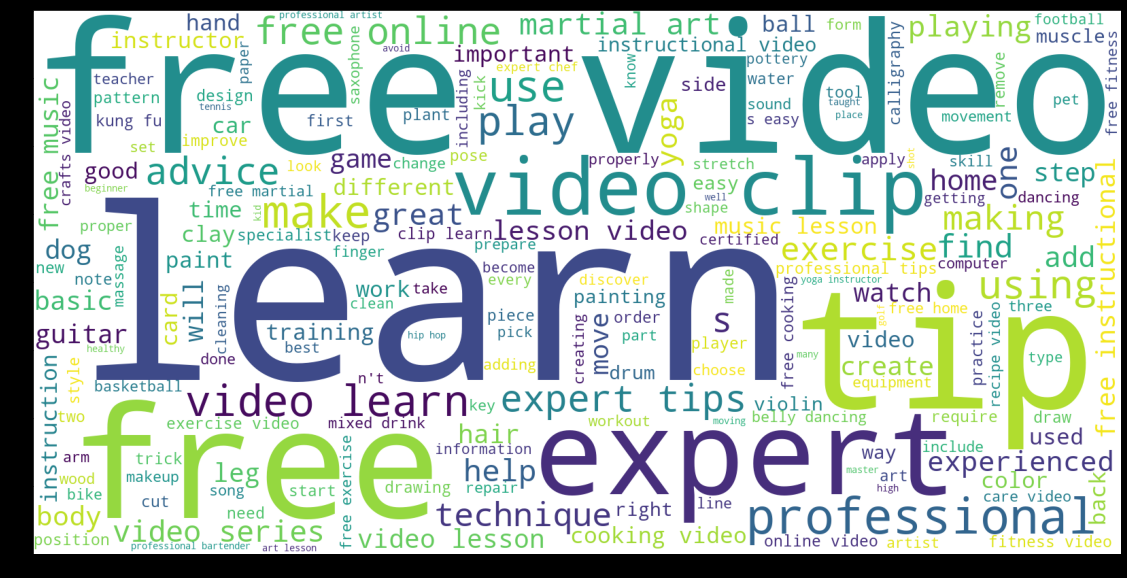

In [14]:

wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(' '.join(how2_df['summary'].tolist()))
plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)



In [15]:
print("Top words in the How2 Articles")
print(wordcloud.words_.keys())


Top words in the How2 Articles
dict_keys(['learn', 'free video', 'tip', 'free', 'expert', 'video clip', 'professional', 'make', 'video learn', 'use', 'play', 'using', 'advice', 'free online', 'expert tips', 's', 'making', 'technique', 'exercise', 'find', 'one', 'great', 'martial art', 'help', 'video series', 'yoga', 'playing', 'add', 'home', 'experienced', 'lesson video', 'body', 'basic', 'dog', 'will', 'move', 'step', 'create', 'game', 'hair', 'leg', 'free instructional', 'guitar', 'free music', 'video lesson', 'watch', 'cooking video', 'music lesson', 'hand', 'work', 'time', 'important', 'card', 'color', 'good', 'training', 'instructor', 'instruction', 'clay', 'back', 'different', 'ball', 'used', 'car', 'video', 'paint', 'instructional video', 'easy', 'drum', 'violin', 'painting', 'muscle', 'side', 'right', 'way', 'professional tips', 'need', 'clip learn', 'art', 'practice', 'water', 'design', 'trick', 'two', 'tool', 'pattern', 'player', 'keep', 'draw', 'drawing', 'first', 'piece', '

#  Step-5 Save dataset as CSV for use in next step (building a model) 

In [16]:
#fxn_removeintro = lambda x: removeintro_cleanup_normalize(x["article"])
# Generate word and sentence count.  

how2_df["num_words_article"] = how2_df['article'].apply(Get_Num_Words)
how2_df["num_sentences_article"] = how2_df['article'].apply(Get_Num_Sentences)

how2_df["num_words_summary"] = how2_df['summary'].apply(Get_Num_Words)
how2_df["num_sentences_summary"] = how2_df['summary'].apply(Get_Num_Sentences)

how2_df["num_words_article_pp1"] = how2_df['article_pp1'].apply(Get_Num_Words)
how2_df["num_sentences_article_pp1"] = how2_df['article_pp1'].apply(Get_Num_Sentences)

how2_df["num_words_article_pp2"] = how2_df['article_pp2'].apply(Get_Num_Words)
how2_df["num_sentences_article_pp2"] = how2_df['article_pp2'].apply(Get_Num_Sentences)

how2_df["num_words_article_pp3"] = how2_df['article_pp3'].apply(Get_Num_Words)
how2_df["num_sentences_article_pp3"] = how2_df['article_pp3'].apply(Get_Num_Sentences)

# write dataframe to file for use in next step of summarization
how2_df.to_csv(os.getcwd() + "/data/how2_df.csv")


how2_df

,summary,article,data_source,article_pp1,article_pp2,article_pp3,num_words_article,num_sentences_article,num_words_summary,num_sentences_summary,num_words_article_pp1,num_sentences_article_pp1,num_words_article_pp2,num_sentences_article_pp2,num_words_article_pp3,num_sentences_article_pp3
0,learn the sivananda yoga single right leg rais...,after you 've done at least six to twelve roun...,How2,done least six twelve round sun salutation siv...,after you 've done at least six to twelve roun...,done least six twelve round sun salutation yog...,231,16,14,2,97,1,217,16,91,1
1,learn how to apply hanger hooks for your woodc...,"on behalf of expert village , my name is husai...",How2,think going hang right okay okay need another ...,we have to think about how that is going to ha...,think going right need another wire need anoth...,146,9,22,2,28,1,68,6,23,1
2,learn about how hand washing can help prevent ...,hi ! this is david jackel on behalf of expert ...,How2,cold come direct contact somebody else virus o...,most colds come from direct conotact that you ...,cold come direct contact somebody else virus o...,359,14,20,2,123,1,284,11,116,1
3,how to julienne cucumbers to make kimchi for k...,the other way we can do cucumbers which is als...,How2,way cucumber also nice pickling cucumber find ...,the other way we can do cucumbers which is als...,way cucumber also nice cucumber find work best...,171,6,26,2,62,1,169,6,56,1
4,in order to put photographic emulsion on water...,my name is anthony maddaloni and i 'm going to...,How2,photograph emulsion heat emulsion light tight ...,now photographs have an emulsion on them .and ...,photograph emulsion heat emulsion light tight ...,149,9,54,3,56,1,124,8,48,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,newfoundlands are giant dogs with very heavy c...,i 'm nancy frensley with the berkeley east bay...,How2,talk newfoundland newfoundland newfies called ...,we 're here to talk about newfoundlands .the n...,talk newfoundland newfoundland people love kee...,187,10,51,3,71,1,164,10,66,1
2516,martial arts stretches focus on increasing fle...,my name is william sampson and i am with unite...,How2,couple basic type stretch appropriate differen...,there are a couple basic types of stretches an...,couple basic type stretch appropriate differen...,618,20,37,3,222,1,570,19,213,1
2517,avoid getting fired at an office christmas par...,"so , you 've just been invited to your office ...",How2,first main thing need remember office christma...,"first of all , the main thing you need to reme...",first main thing need remember office christma...,316,11,49,3,89,1,242,9,87,1
2518,how to select stones for thinning in this free...,"hi , i 'm john olsen for expert village . and ...",How2,manipulate back forth chipping small flake fat...,and i manipulate that back and forth by chippi...,manipulate back forth chipping small flake fat...,376,24,12,2,125,1,317,20,116,1
